In [1]:
import config
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from IPython.display import display
import json
import datetime
import math
import joblib
from PIL import Image
from sklearn.preprocessing import StandardScaler

In [2]:
today = datetime.date.today()

base_dir = config.RAW_DATA_PATH
proc_dir = config.PROC_DATA_PATH

img_path = os.path.join(base_dir, 'images_knee')

# rawimg_folder = "2025-09-13_hdbscan_img"
# rawimg_folder_date = rawimg_folder.split('_')[0]
# rawimg_run = "run32"

# feature_folder = "2025-08-11_hdbscan"
# feature_folder_date = feature_folder.split('_')[0]
# feature_run = "run22"

# rawimg_filepath =  os.path.join(proc_dir, "radiographic_features", rawimg_folder, rawimg_run)
# feature_filepath =  os.path.join(proc_dir, "radiographic_features", feature_folder, feature_run)

ques_folder = "2025-08-23_hdbscan"
ques_folder_date = ques_folder.split('_')[0]
ques_run = "run2"

ques_filepath = os.path.join(proc_dir, ques_folder, "questionnaire", ques_run)

ques = pd.read_csv(os.path.join(ques_filepath, "questionnaire_run2_umap_hdbscan_scaled_wKL_v2.csv" ))
display(ques.head())

,index,id,record_id,visit,side,pain,age,ce_height,ce_weight,ce_bmi,...,koos_sp2,koos_sp3,koos_sp4,koos_sp5,koos_q1,koos_q2,koos_q3,koos_q4,cluster_label,probability
0,0,IM0001_1_left,IM0001,1,l,0.0,41,183.0,82.1,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.472182
1,1,IM0002_1_left,IM0002,1,l,0.0,40,175.0,72.9,23.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
2,2,IM0004_1_left,IM0004,1,l,0.0,55,151.0,55.2,24.2,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.997089
3,3,IM0005_1_left,IM0005,1,l,0.0,46,184.5,98.5,28.9,...,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,0.686842
4,4,IM0008_1_left,IM0008,1,l,0.0,51,166.0,71.5,25.9,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.927332


In [3]:
# scaler = joblib.load(os.path.join(rawimg_filepath, "scaler.pkl"))
from utils.load_utils import load_image_folder_as_array

In [4]:
clusters = ques['cluster_label'].unique()
clusters.sort()

print(f"Number of clusters: {len(clusters)}")

Number of clusters: 5


In [5]:
files = os.listdir(img_path)
files = [f for f in files if f.endswith('.png')]
print(f"Number of image files: {len(files)}")

Number of image files: 427


In [6]:
names = []
X = []
for subdir in ['train', 'test']:
    feature_dir = os.path.join(img_path, subdir)
    X_sub, _, _ = load_image_folder_as_array(feature_dir, image_size=(256, 256))
    X.extend(X_sub)
scaler = StandardScaler()
scaler.fit(X)

,copy,True
,with_mean,True
,with_std,True


In [7]:
def load_image(im_path, image_size=(256, 256)):
    img = Image.open(im_path).convert('L').resize(image_size) # Convert to grayscale
    img_array = np.array(img)
    img_array = img_array.flatten()  # Flatten the image to a vector
    img_array = img_array.reshape(1, -1)
    return img_array

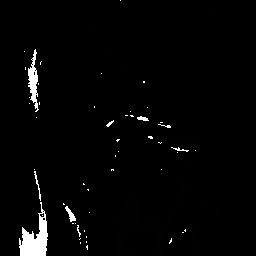

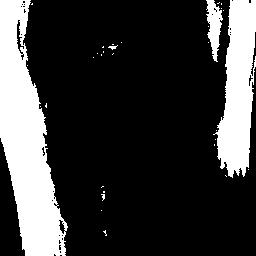

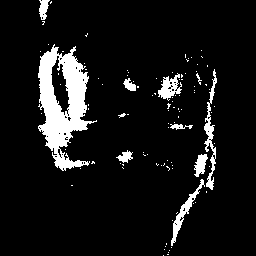

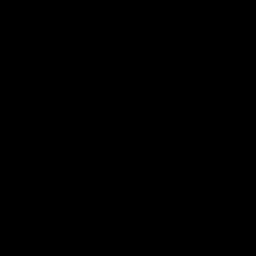

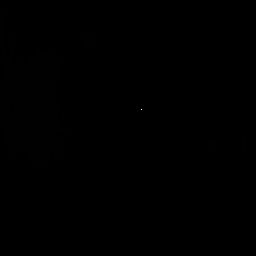

In [8]:
for cluster in clusters:
    df_temp = ques[ques['cluster_label'] == cluster]
    cluster_ids = df_temp['id'].tolist()

    filenames = [f"{id}.png" for id in cluster_ids]
    images = [os.path.join(img_path, fname) for fname in filenames if os.path.exists(os.path.join(img_path, fname))]

    w, h = 256, 256
    n = len(images)

    arr = np.zeros((h, w), np.float32)

    for im in images:
        imarr = np.array(scaler.transform(load_image(im)), dtype=float)
        imarr = imarr.reshape(h, w)
        arr = arr + imarr / n
    
    arr = np.array(np.round(arr), dtype=np.uint8)
    out = Image.fromarray(arr)
    out.save(os.path.join(ques_filepath, f"average_cluster_{cluster}.png"))
    out.show()
    